In [1]:
import torch
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
torch.cuda.device_count()
print(torch.version.cuda)
#import matplotlib.pyplot as plt


10.1


Building model...
Start training...
    Step:   500 avg_batch_loss: 1.61303
    Step:  1000 avg_batch_loss: 1.21887
    Step:  1500 avg_batch_loss: 1.07480
    Finish training this EPOCH, start evaluating...
EPOCH: 1 train_loss: 0.02934 train_acc: 0.67132 test_loss: 0.03183 test_acc 0.64590
    Step:   500 avg_batch_loss: 0.89273
    Step:  1000 avg_batch_loss: 0.85342
    Step:  1500 avg_batch_loss: 0.80045
    Finish training this EPOCH, start evaluating...
EPOCH: 2 train_loss: 0.02005 train_acc: 0.77228 test_loss: 0.02521 test_acc 0.72070
    Step:   500 avg_batch_loss: 0.65965
    Step:  1000 avg_batch_loss: 0.67150
    Step:  1500 avg_batch_loss: 0.66137
    Finish training this EPOCH, start evaluating...
EPOCH: 3 train_loss: 0.01505 train_acc: 0.83162 test_loss: 0.02301 test_acc 0.74830
    Step:   500 avg_batch_loss: 0.49478
    Step:  1000 avg_batch_loss: 0.51600
    Step:  1500 avg_batch_loss: 0.53719
    Finish training this EPOCH, start evaluating...
EPOCH: 4 train_loss: 0.0

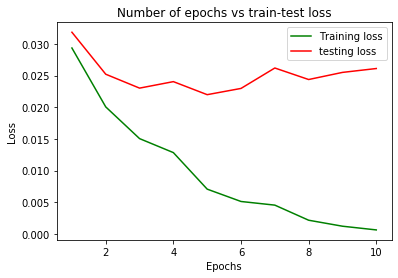

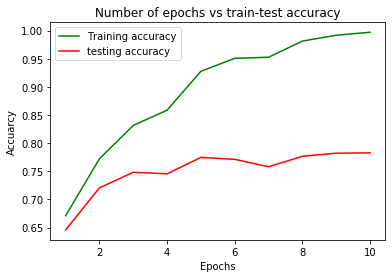

In [34]:
from __future__ import print_function
from __future__ import division
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
#from tensorboardX import SummaryWriter  # for pytorch below 1.14
from torch.utils.tensorboard import SummaryWriter # for pytorch above or equal 1.14

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        
        self.batchn=nn.BatchNorm1d(512,affine=True,)
        
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        
        x=self.batchn(x)
        x=F.relu(x)
        
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

def eval_net(dataloader):
    correct = 0
    total = 0
    total_loss = 0
    net.eval() # Why would I do this?
    criterion = nn.CrossEntropyLoss(reduction='mean')
    for data in dataloader:
        images, labels = data
        images, labels = Variable(images).cuda(), Variable(labels).cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    net.train() # Why would I do this?
    return total_loss / total, correct.float() / total

if __name__ == "__main__":
    BATCH_SIZE = 32 #mini_batch size
    MAX_EPOCH = 10 #maximum epoch to train
    
    #trainLossList,testLossList,trainAccList,testAccList=[],[],[],[]
    trainLossListBn,testLossListBn,trainAccListBn,testAccListBn=[],[],[],[]
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #torchvision.transforms.Normalize(mean, std)

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    print('Building model...')
    net = Net().cuda()
    net.train() # Sets the model in training mode

    writer = SummaryWriter(log_dir='./log')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    print('Start training...')
    for epoch in range(MAX_EPOCH):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:    # print every 2000 mini-batches
                print('    Step: %5d avg_batch_loss: %.5f' %
                      (i + 1, running_loss / 500))
                running_loss = 0.0
        print('    Finish training this EPOCH, start evaluating...')
        train_loss, train_acc = eval_net(trainloader)
        test_loss, test_acc = eval_net(testloader)
        print('EPOCH: %d train_loss: %.5f train_acc: %.5f test_loss: %.5f test_acc %.5f' %
              (epoch+1, train_loss, train_acc, test_loss, test_acc))

        writer.add_scalar('train_loss', train_loss)
        writer.add_scalar('test_loss', test_loss)
        
        trainLossListBn.append(train_loss)
        testLossListBn.append(test_loss)
        trainAccListBn.append(train_acc)
        testAccListBn.append(test_acc)
        
        

    writer.close()
    print('Finished Training')
    print('Saving model...')
    torch.save(net.state_dict(), 'mytrainingBN.pth')
    
    plt.plot(range(1,11),trainLossListBn, 'g')
    plt.plot(range(1,11),testLossListBn, 'red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Number of epochs vs train-test loss")
    plt.gca().legend(("Training loss","testing loss"))
    plt.savefig("TrainTestLossWithBatchNorm.png")
    plt.show()
    
    plt.plot(range(1,11),trainAccListBn, 'g')
    plt.plot(range(1,11),testAccListBn, 'red')
    plt.xlabel("Epochs")
    plt.ylabel("Accuarcy")
    plt.title("Number of epochs vs train-test accuracy")
    plt.gca().legend(("Training accuracy","testing accuracy"))
    plt.savefig("TrainTestAccuarcyWithBatchNorm.png")
    plt.show()
    
    

    


In [25]:
testAccList=[0.577,0.684,0.7078,0.7343,0.7277,0.7097,0.7218,0.7363,0.7276,0.7359]

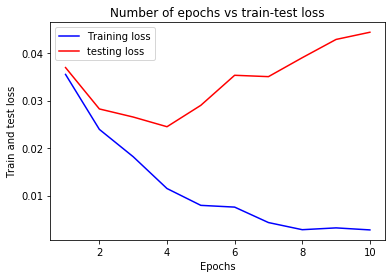

In [29]:
plt.plot(range(1,11),trainLossList, 'blue')
plt.plot(range(1,11),testLossList, 'red')
plt.xlabel("Epochs")
plt.ylabel("Train and test loss")
plt.title("Number of epochs vs train-test loss")
plt.gca().legend(("Training loss","testing loss"))
plt.savefig("TrainTestLossWithoutBatchNorm.png")
plt.show()



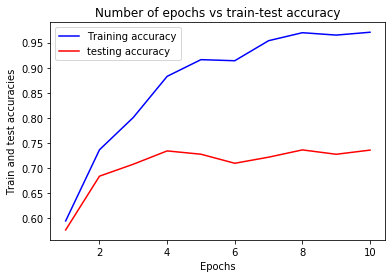

In [30]:
plt.plot(range(1,11),trainAccList, 'b')
plt.plot(range(1,11),testAccList, 'r')
plt.xlabel("Epochs")
plt.ylabel("Train and test accuracies")
plt.title("Number of epochs vs train-test accuracy")
plt.gca().legend(("Training accuracy","testing accuracy"))
plt.savefig("TrainAccTestAccWithtBatchNorm")
plt.show()


Building model...
Start training...
    Step:   500 avg_batch_loss: 0.33373
    Step:  1000 avg_batch_loss: 0.11490
    Step:  1500 avg_batch_loss: 0.13047
    Finish training this EPOCH, start evaluating...
EPOCH: 1 train_loss: 0.00206 train_acc: 0.97846 test_loss: 0.03151 test_acc 0.76170
    Step:   500 avg_batch_loss: 0.11042
    Step:  1000 avg_batch_loss: 0.13750
    Step:  1500 avg_batch_loss: 0.17251
    Finish training this EPOCH, start evaluating...
EPOCH: 2 train_loss: 0.00222 train_acc: 0.97518 test_loss: 0.03366 test_acc 0.75580
    Step:   500 avg_batch_loss: 0.11290
    Step:  1000 avg_batch_loss: 0.12609
    Step:  1500 avg_batch_loss: 0.14773
    Finish training this EPOCH, start evaluating...
EPOCH: 3 train_loss: 0.00297 train_acc: 0.96698 test_loss: 0.03575 test_acc 0.75280
    Step:   500 avg_batch_loss: 0.09875
    Step:  1000 avg_batch_loss: 0.10153
    Step:  1500 avg_batch_loss: 0.12438
    Finish training this EPOCH, start evaluating...
EPOCH: 4 train_loss: 0.0

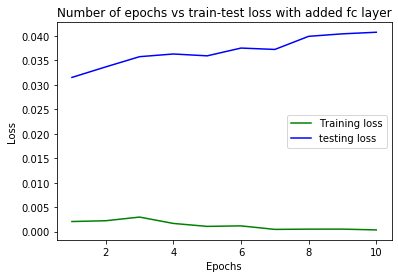

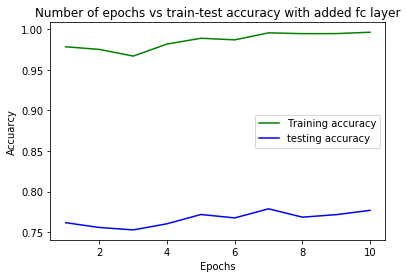

In [50]:
from __future__ import print_function
from __future__ import division
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
#from tensorboardX import SummaryWriter  # for pytorch below 1.14
from torch.utils.tensorboard import SummaryWriter # for pytorch above or equal 1.14

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        
        self.batchn=nn.BatchNorm1d(512,affine=True,)
        
        self.new_fc=nn.Linear(512,512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        
        x=self.batchn(x)
        x=F.relu(x)
        
        x=self.new_fc(x)
        
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

def eval_net(dataloader):
    correct = 0
    total = 0
    total_loss = 0
    net.eval() # Why would I do this?
    criterion = nn.CrossEntropyLoss(reduction='mean')
    for data in dataloader:
        images, labels = data
        images, labels = Variable(images).cuda(), Variable(labels).cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    net.train() # Why would I do this?
    return total_loss / total, correct.float() / total

if __name__ == "__main__":
    BATCH_SIZE = 32 #mini_batch size
    MAX_EPOCH = 10 #maximum epoch to train
    
    #trainLossList,testLossList,trainAccList,testAccList=[],[],[],[]
    trainLossListBn,testLossListBn,trainAccListBn,testAccListBn=[],[],[],[]
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #torchvision.transforms.Normalize(mean, std)

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    print('Building model...')
    net = Net().cuda()
    net.train() # Sets the model in training mode

    writer = SummaryWriter(log_dir='./log')
    
    pre_trained_wts=torch.load('mytrainingBN.pth')
    model_dict=net.state_dict()
    for key in model_dict:
        if key in pre_trained_wts and key!='fc2.weight' and key!='fc2.bias':
            model_dict[key]=pre_trained_wts[key]
    net.load_state_dict(model_dict)
    
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    print('Start training...')
    for epoch in range(MAX_EPOCH):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:    # print every 2000 mini-batches
                print('    Step: %5d avg_batch_loss: %.5f' %
                      (i + 1, running_loss / 500))
                running_loss = 0.0
        print('    Finish training this EPOCH, start evaluating...')
        train_loss, train_acc = eval_net(trainloader)
        test_loss, test_acc = eval_net(testloader)
        print('EPOCH: %d train_loss: %.5f train_acc: %.5f test_loss: %.5f test_acc %.5f' %
              (epoch+1, train_loss, train_acc, test_loss, test_acc))

        writer.add_scalar('train_loss', train_loss)
        writer.add_scalar('test_loss', test_loss)
        
        trainLossListBn.append(train_loss)
        testLossListBn.append(test_loss)
        trainAccListBn.append(train_acc)
        testAccListBn.append(test_acc)
        
        

    writer.close()
    print('Finished Training')
    print('Saving model...')
    torch.save(net.state_dict(), 'mytrainingBN2.pth')
    
    plt.plot(range(1,11),trainLossListBn, 'g')
    plt.plot(range(1,11),testLossListBn, 'b')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Number of epochs vs train-test loss with added fc layer")
    plt.gca().legend(("Training loss","testing loss"))
    plt.savefig("TrainTestLossWithNewFc.png")
    plt.show()
    
    plt.plot(range(1,11),trainAccListBn, 'g')
    plt.plot(range(1,11),testAccListBn, 'b')
    plt.xlabel("Epochs")
    plt.ylabel("Accuarcy")
    plt.title("Number of epochs vs train-test accuracy with added fc layer")
    plt.gca().legend(("Training accuracy","testing accuracy"))
    plt.savefig("TrainTestAccuarcyWithNewFc.png")
    plt.show()
    
    

    


In [12]:
from __future__ import print_function
from __future__ import division
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
#from tensorboardX import SummaryWriter  # for pytorch below 1.14
from torch.utils.tensorboard import SummaryWriter # for pytorch above or equal 1.14


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        
        self.batchn=nn.BatchNorm1d(512,affine=True,)
        
        #self.new_fc=nn.Linear(512,512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        
        x=self.batchn(x)
        x=F.leaky_relu(x)
        
        #x=self.new_fc(x)
        
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

def eval_net(dataloader):
    correct = 0
    total = 0
    total_loss = 0
    net.eval() # Why would I do this?
    criterion = nn.CrossEntropyLoss(reduction='mean')
    for data in dataloader:
        images, labels = data
        images, labels = Variable(images).cuda(), Variable(labels).cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    net.train() # Why would I do this?
    return total_loss / total, correct.float() / total

if __name__ == "__main__":
    BATCH_SIZE = 32 #mini_batch size
    MAX_EPOCH = 8 #maximum epoch to train
    
    trainLossList,testLossList,trainAccList,testAccList=[],[],[],[]
    #trainLossListBn,testLossListBn,trainAccListBn,testAccListBn=[],[],[],[]
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #torchvision.transforms.Normalize(mean, std)
    
    parameters=dict(lr=[0.01,0.001],batch_size=[32,64])
    parameters=[v for v in paramters.values()]
    
    #Main for loop
    for lr,batch_size in product(*parameters):
    
        comment = f' batch_size={batch_size} lr={lr}'
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=False, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                  shuffle=True, num_workers=2)

        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=False, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                 shuffle=False, num_workers=2)

        classes = ('plane', 'car', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        print('Building model...')
        net = Net().cuda()
        net.train() # Sets the model in training mode

        #Tensorboard visualizations


        writer = SummaryWriter(log_dir='./runs/hyperParams',comment=comment)
        

        #writer.close()


    #     pre_trained_wts=torch.load('mytrainingBN.pth')
    #     model_dict=net.state_dict()
    #     for key in model_dict:
    #         if key in pre_trained_wts and key!='fc2.weight' and key!='fc2.bias':
    #             model_dict[key]=pre_trained_wts[key]
    #     net.load_state_dict(model_dict)



        criterion = nn.CrossEntropyLoss()
        #optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
        #optimizer=optim.Adam(net.parameters(),lr=lr)
        optimizer=optim.Adagrad(net.parameters(),lr=lr)

        print('Start training...')
        for epoch in range(MAX_EPOCH):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                #writer.add_graph(net,inputs)
                # zero the parameter gradients
                optimizer.zero_grad()


    #           im,lb=next(iter(trainloader))

                # forward + backward + optimize


                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 500 == 499:    # print every 2000 mini-batches
                    print('    Step: %5d avg_batch_loss: %.5f' %
                          (i + 1, running_loss / 500))
                    running_loss = 0.0
            print('    Finish training this EPOCH, start evaluating...')
            train_loss, train_acc = eval_net(trainloader)
            test_loss, test_acc = eval_net(testloader)
            print('EPOCH: %d train_loss: %.5f train_acc: %.5f test_loss: %.5f test_acc %.5f' %
                  (epoch+1, train_loss, train_acc, test_loss, test_acc))

            #writer.add_scalar('Loss', train_loss, epoch)
            #writer.add_scalar('Number Correct', total_correct, epoch)
            writer.add_graph(net,inputs)
            writer.add_scalar('Train Accuracy', train_acc, epoch)
            writer.add_scalar('Test Accuracy', test_acc, epoch)

            writer.add_scalar('train_loss', train_loss,epoch)
            writer.add_scalar('test_loss', test_loss,epoch)
            
            for name, param in net.named_parameters():

                #writer.add_histogram('conv1.bias', net.conv1.bias, epoch)
                writer.add_histogram(name,param, epoch)
                writer.add_histogram(f'{name}.grad' ,param.grad ,epoch)



            trainLossList.append(train_loss)
            testLossList.append(test_loss)
            trainAccList.append(train_acc)
            testAccList.append(test_acc)

    
        print('Finished Training')
        print('Saving model...')
        writer.close()
        #torch.save(net.state_dict(), 'mytrainingLeakyRelu.pth')

    #     plt.plot(range(1,11),trainLossList, 'orange')
    #     plt.plot(range(1,11),testLossList, 'blue')
    #     plt.xlabel("Epochs")
    #     plt.ylabel("Loss")
    #     plt.title("Number of epochs vs train-test loss with 16 hidden units")
    #     plt.gca().legend(("Training loss","testing loss"))
    #     plt.savefig("TrainTestLossWithHu.png")
    #     plt.grid(True)
    #     plt.show()

    #     plt.plot(range(1,11),trainAccList, 'orange')
    #     plt.plot(range(1,11),testAccList, 'blue')
    #     plt.xlabel("Epochs")
    #     plt.ylabel("Accuarcy")
    #     plt.title("Number of epochs vs train-test accuracy with 16 hidden units")
    #     plt.gca().legend(("Training accuracy","testing accuracy"))
    #     plt.savefig("TrainTestAccuarcyWithHu.png")
    #     plt.grid(True)
    #     plt.show()


Building model...
Start training...
    Step:   500 avg_batch_loss: 1.51222
    Step:  1000 avg_batch_loss: 1.15701
    Step:  1500 avg_batch_loss: 1.01686
    Finish training this EPOCH, start evaluating...
EPOCH: 1 train_loss: 0.02967 train_acc: 0.66756 test_loss: 0.03174 test_acc 0.64030
    Step:   500 avg_batch_loss: 0.86228
    Step:  1000 avg_batch_loss: 0.81086
    Step:  1500 avg_batch_loss: 0.78942
    Finish training this EPOCH, start evaluating...
EPOCH: 2 train_loss: 0.02034 train_acc: 0.77394 test_loss: 0.02441 test_acc 0.72530
    Step:   500 avg_batch_loss: 0.66033
    Step:  1000 avg_batch_loss: 0.66114
    Step:  1500 avg_batch_loss: 0.62635
    Finish training this EPOCH, start evaluating...
EPOCH: 3 train_loss: 0.01576 train_acc: 0.82834 test_loss: 0.02232 test_acc 0.75110
    Step:   500 avg_batch_loss: 0.52966
    Step:  1000 avg_batch_loss: 0.52266
    Step:  1500 avg_batch_loss: 0.52740
    Finish training this EPOCH, start evaluating...
EPOCH: 4 train_loss: 0.0

In [7]:
from itertools import product

for lr, batch_size in product(*parameters): 
    print(lr, batch_size)

0.01 32
0.01 64
0.001 32
0.001 64


In [83]:
writer =SummaryWriter()
images,labels=next(iter(trainloader))
#print(images)
#images=torch.tensor(images[0][1])
images=Variable(images).cuda()
grid=torchvision.utils.make_grid(images)
writer.add_image('images',grid)

writer.close()

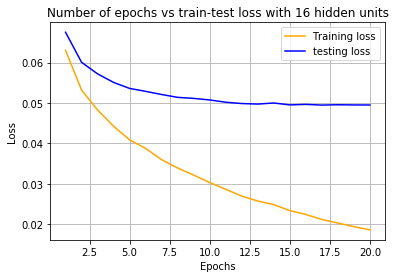

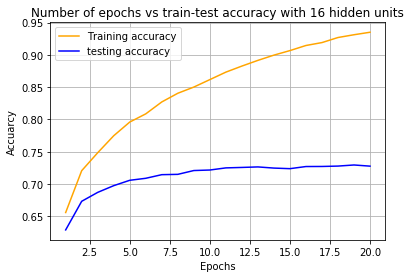

In [60]:
plt.plot(range(1,21),trainLossList, 'orange')
plt.plot(range(1,21),testLossList, 'blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Number of epochs vs train-test loss with 16 hidden units")
plt.gca().legend(("Training loss","testing loss"))
plt.savefig("TrainTestLossWithHu.png")
plt.grid(True)
plt.show()
    
plt.plot(range(1,21),trainAccList, 'orange')
plt.plot(range(1,21),testAccList, 'blue')
plt.xlabel("Epochs")
plt.ylabel("Accuarcy")
plt.title("Number of epochs vs train-test accuracy with 16 hidden units")
plt.gca().legend(("Training accuracy","testing accuracy"))
plt.savefig("TrainTestAccuarcyWithHu.png")
plt.grid(True)
plt.show()

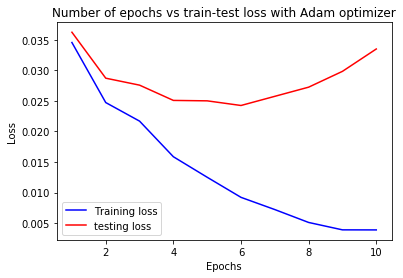

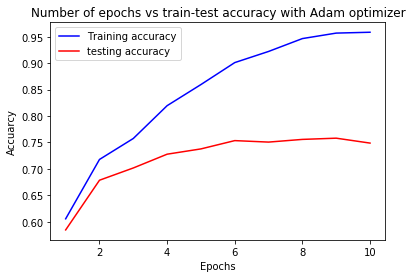

In [52]:
# plt.plot(range(1,11),[0.03456,0.02473,0.02169,0.01586,0.01250,0.00921,0.00721,0.00510,0.00389,0.00388], 'b')
# plt.plot(range(1,11),[0.03624,0.02872,0.02758,0.02508,0.02501,0.02425,0.02575,0.02725,0.02984,0.03350], 'r')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Number of epochs vs train-test loss with Adam optimizer")
# plt.gca().legend(("Training loss","testing loss"))
# plt.savefig("TrainTestLossWithAdam.png")
# plt.show()
    
# plt.plot(range(1,11),[0.60546,0.71782,0.75754,0.81966,0.85966,0.90124,0.92234,0.94670,0.95708,0.95870], 'b')
# plt.plot(range(1,11),[0.58440,0.67850,0.70170,0.72780,0.73780,0.75350,0.75070,0.75580,0.758110,0.74880], 'r')
# plt.xlabel("Epochs")
# plt.ylabel("Accuarcy")
# plt.title("Number of epochs vs train-test accuracy with Adam optimizer")
# plt.gca().legend(("Training accuracy","testing accuracy"))
# plt.savefig("TrainTestAccuarcyWithAdam.png")
# plt.show()
    